In [1]:
!nvidia-smi

Fri Apr 17 13:54:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   26C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [3]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [4]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise Error(f'File {filepath} doesn\'t exist')

In [5]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Replace any of '.', '!', '?' by ' .', ' !', ' ?'. \1 means the 1st bracked group. r is to not consider \1
    s = re.sub(r'([,.!?0-9])', r' \1', s)
    # Remove any character which is not in [^a-zA-Z0-9,.!?]
    s = re.sub(r'[^a-zA-Z0-9,.!?]', r' ', s)
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [6]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.87 s, sys: 1.27 s, total: 5.14 s
Wall time: 5.13 s


In [7]:
%%time
pairs = np.random.choice(pairs, size=200000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 200,000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l Union europeenne doivent etre ouvertes , transparentes et , par dessus tout , sures .
	EN => The procedures whereby such products come in and out of the European Union have to be open , transparent and , above all , safe .
CPU times: user 33.8 s, sys: 89.9 ms, total: 33.9 s
Wall time: 34 s


In [8]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

MAX_LENGTH = 20

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
examples = [*filter(lambda example: len(example.src) <= MAX_LENGTH and len(example.dest) <= MAX_LENGTH, examples)]
print(f'Number of examples after filtering: {len(examples):,}')

100%|██████████| 200000/200000 [01:18<00:00, 2541.84it/s]


Number of examples after filtering: 61,154


In [9]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples)}')
print(f'valid set size: {len(valid_data.examples)}')
print(f'test set size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train set size: 48923
valid set size: 6116
test set size: 6115
{'src': ['.', 'crees', 'seront', 'emplois', 'nouveaux', 'de', ',', 'seulement', 'alors', 'et', ',', 'alors'], 'dest': ['then', 'and', 'only', 'then', 'will', 'new', 'jobs', 'be', 'created', '.']}


In [10]:
%%time
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 6,589
Length of EN vocabulary: 5,596
CPU times: user 755 ms, sys: 0 ns, total: 755 ms
Wall time: 754 ms


In [76]:
class Encoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_size, hidden_size,
                          num_layers=n_layers, bidirectional=True,
                          dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, hidden_size]
            hn: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, hn = self.gru(packed)
        # hn: [num_layers * 2, batch_size, hidden_size]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs: [seq_len, batch_size, hidden_size * 2]
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        
        hn = torch.cat((hn[:self.n_layers, :, :], hn[self.n_layers:, :, :]), dim=2)
        hn = torch.tanh(self.fc(hn))
        return outputs, hn

In [149]:
class Attention(nn.Module):
    
    def __init__(self, hidden_size, method):
        if method not in ['dot', 'general', 'concat']:
            raise NotImplemented(f'The {method} attention is not defined!')
        
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.method = method
        if method == 'general':
            self.W = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == 'concat':
            self.W = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weights = nn.Linear(hidden_size, 1, bias=False)
            
    def forward(self, h_state, enc_outputs, mask):
        """
        :params
            h_state: Tensor[n_layers, batch_size, hidden_size]
            enc_outputs: Tensor[seq_len, batch_size, hidden_size]
            mask: Tensor[batch_size, seq_len]
            
        :return
            attn_weights: Tensor[batch_size, seq_len, 1]
        """
        if h_state.shape[0] > 1:
            h_state = h_state.sum(dim=0) # [batch_size, hidden_size]
            h_state = h_state.unsqueeze(0) # [1, batch_size, hidden_size]
            
        # Compute Attention weights
        if self.method == 'dot':
            h_state = h_state.permute(1, 2, 0) # [batch_size, hidden_size, 1]
            enc_outputs = enc_outputs.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]
            alignement_scores = torch.bmm(enc_outputs, h_state) # [batch_size, seq_len, 1]
        elif self.method == 'general':
            h_state = h_state.permute(1, 0, 2) # [batch_size, 1, hidden_size]
            x = self.W(h_state) # [batch_size, 1, hidden_size]
            x = x.permute(0, 2, 1) # [batch_size, hidden_size, 1]
            enc_outputs = enc_outputs.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]
            alignement_scores = torch.bmm(enc_outputs, x) # [batch_size, seq_len, 1]
        elif self.method == 'concat':
            concat = h_state + enc_outputs # [seq_len, batch_size, hidden_size]
            concat = torch.tanh(self.W(concat)) # [seq_len, batch_size, hidden_size]
            concat = concat.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]
            alignement_scores = self.weights(concat) # [batch_size, seq_len, 1]
            
        # Compute Attention Weights
        mask = mask.unsqueeze(2) # [batch_size, seq_len, 1]
        alignement_scores = alignement_scores.masked_fill(mask == 0, -1e10) # Don't account pad token
        attn_weights = F.softmax(alignement_scores, dim=1) # [batch_size, seq_len, 1]
        
        return attn_weights

In [150]:
class LuongDecoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout, attention):
        super(LuongDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_size, hidden_size,
                          num_layers=n_layers,
                          dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.attention = attention
        self.fc = nn.Linear(hidden_size + embedding_size, vocab_size)
        
    def forward(self, input_word_index, h_state, enc_outputs, mask):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[n_layers, batch_size, hidden_size]
            enc_outputs: Tensor[seq_len, batch_size, hidden_size]
            mask: Tensor[batch_size, seq_len]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[n_layers, batch_size, hidden_size]
            attn_weights: Tensor[batch_size, seq_len]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = self.dropout(embedded)
        # embedded: [1, batch_size, embedding_size]
        
        # Pass through RNN
        output, h_state = self.gru(embedded, h_state)
        
        # Compute Attention Weights
        attn_weights = self.attention(h_state, enc_outputs, mask) # [batch_size, seq_len, 1]
        
        # Compute Context Vector
        enc_outputs = enc_outputs.permute(1, 2, 0) # [batch_size, hidden_size, seq_len]
        context_vector = torch.bmm(enc_outputs, attn_weights) # [batch_size, hidden_size, 1]
        
        # Concat Context Vector and embedded input
        context_vector = context_vector.permute(2, 0, 1) # [1, batch_size, hidden_size]
        new_input = torch.cat((embedded, context_vector), dim=2) # [1, batch_size, hidden_size + emdedding_size]
        
        # Pass through FC layer
        logit = self.fc(new_input.squeeze(0)) # [batch_size, vocab_size]
        
        return logit, h_state, attn_weights.squeeze(2)

In [151]:
class SeqToSeqNet(nn.Module):
    
    def __init__(self, encoder, decoder, pad_index, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_index = pad_index
        self.device = device
        
    def create_mask(self, input_sequences):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            
        :return
            mask: Tensor[batch_size, seq_len]
        """
        mask = (input_sequences != self.pad_index).permute(1, 0)
        return mask
        
    def forward(self, input_sequences, sequence_lengths, target_sequences, tf_ratio):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            target_sequences: Tensor[seq_len, batch_size]
            tf_ratio: float
            
        :return
            outputs: Tensor[seq_len - 1, batch_size, vocab_size]
                Since we ignore the SOS_TOKEN
        """
        mask = self.create_mask(input_sequences)
        
        enc_outputs, h_state = self.encoder(input_sequences, sequence_lengths)
        
        seq_len, batch_size = target_sequences.size()
        outputs = torch.zeros(seq_len - 1, batch_size, self.decoder.vocab_size).to(self.device)
        word_index = target_sequences[0, :]       
        
        for t, idx in enumerate(range(1, seq_len)):
            output, h_state, _ = self.decoder(word_index, h_state, enc_outputs, mask)
            # output: [batch_size, vocab_size]
            outputs[t] = output
            
            if random.random() < tf_ratio:
                word_index = target_sequences[idx, :]
            else:
                word_index = output.argmax(dim=1)
                
        return outputs

In [152]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [153]:
def train_epoch(model, opt, loss_func, tf_ratio, data_it, grad_clip, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        outputs = model(*data.src, data.dest, tf_ratio)
        # *data.src: unpack input_sequences and sequence_lengths
        loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
        loss.backward()
        # plot_gradient_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'loss:     {epoch_loss / (i + 1):.3f} - ppl:     {np.exp(epoch_loss / (i + 1)):7.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [154]:
def valid_epoch(model, loss_func, data_it, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            outputs = model(*data.src, data.dest, 0) # Turn-off the teacher forcing
            loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'val_loss: {epoch_loss / (i + 1):.3f} - val_ppl: {np.exp(epoch_loss / (i + 1)):7.3f}')
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [155]:
def train(model, opt, loss_func, train_it, valid_it, tf_ratio, n_epochs, grad_clip, save_to, filename):
    assert callable(loss_func)
    if not os.path.exists(save_to):
        !mkdir {save_to}
    
    history = {
        'loss': [],
        'val_loss': [],
        'ppl': [],
        'val_ppl': []
    }
    best_loss = [float('inf')]
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss, ppl = train_epoch(model=model, opt=opt, loss_func=loss_func, tf_ratio=tf_ratio,
                                data_it=train_it, grad_clip=grad_clip, epoch_text=epoch_text)
        val_loss, val_ppl = valid_epoch(model=model, loss_func=loss_func, data_it=valid_it, epoch_text=epoch_text)
        
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['ppl'].append(ppl)
        history['val_ppl'].append(val_ppl)
        
        # Reduce tf_ratio
        tf_ratio = tf_ratio - tf_ratio / (epoch + 2)
        
        # Saving
        if val_loss < best_loss[-1]:
            best_loss.append(val_loss)
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict()
            }, f=os.path.join(save_to, filename))
            
        # Stop training
        try:
            if val_loss > best_loss[-2]:
                print('Stop training because the loss is increasing!')
                break
        except IndexError:
            pass
        
    return history

In [156]:
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256
N_LAYERS = 1
DROPOUT = 0.25
RECURRENT_DROPOUT = 0.35
GRAD_CLIP = 1.0
BATCH_SIZE = 64
N_EPOCHS = 15
TF_RATIO = 0.5

In [157]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [158]:
encoder = Encoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT,
                  recurrent_dropout=RECURRENT_DROPOUT).to(device)
attn = Attention(hidden_size=HIDDEN_SIZE,
                 method='concat').to(device)
decoder = LuongDecoder(embedding_size=EMBEDDING_DIM,
                       vocab_size=len(EN.vocab),
                       hidden_size=HIDDEN_SIZE,
                       n_layers=N_LAYERS,
                       dropout=DROPOUT,
                       recurrent_dropout=RECURRENT_DROPOUT,
                       attention=attn).to(device)
seq2seq = SeqToSeqNet(encoder=encoder,
                      decoder=decoder,
                      pad_index=FR.vocab.stoi[FR.pad_token],
                      device=device).to(device)
opt_adam = optim.Adam(seq2seq.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 4,800,604


In [159]:
%%time
history = train(model=seq2seq,
                opt=opt_adam,
                loss_func=criterion,
                train_it=train_iterator,
                valid_it=valid_iterator,
                tf_ratio=TF_RATIO,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                save_to='./saved_models',
                filename='seq2seq-luong-attn.pt')

Epoch: 11 - val_loss: 3.600 - val_ppl:  36.607: 100%|██████████| 96/96 [00:05<00:00, 18.78it/s]

Stop training because the loss is increasing!
CPU times: user 16min 22s, sys: 19.2 s, total: 16min 42s
Wall time: 12min 15s


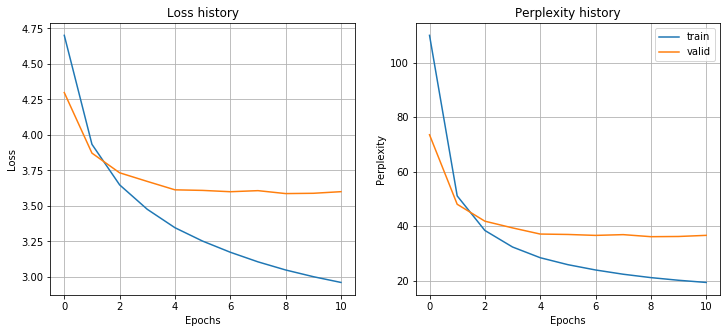

In [160]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
plt.legend()
plt.show()

In [161]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq-luong-attn.pt').get('model'))

<All keys matched successfully>

In [162]:
val_loss, val_ppl = valid_epoch(model=seq2seq,
                                loss_func=criterion,
                                data_it=test_iterator,
                                epoch_text='Evaluation on test set - ')

Evaluation on test set - val_loss: 3.634 - val_ppl:  37.878: 100%|██████████| 96/96 [00:03<00:00, 24.85it/s]


In [163]:
class Inference:
    
    def __init__(self, model, src_field, dest_field, normalizer, max_length, device):
        assert callable(normalizer)
        
        self.model = model
        self.src_field = src_field
        self.dest_field = dest_field
        self.normalizer = normalizer
        self.max_length = max_length
        self.device = device
    
    def encode(self, sentence):
        sentence = self.normalizer(sentence)
        sentence = self.src_field.preprocess(sentence)
        input_sequence, sequence_length = self.src_field.process([sentence])
        input_sequence = input_sequence.to(self.device)
        sequence_length = sequence_length.to(self.device)
        mask = self.model.create_mask(input_sequence)
        enc_outputs, h_state = self.model.encoder(input_sequence, sequence_length)
        return enc_outputs, h_state, mask
    
    def greedy(self, sentence):
        """
        Translate using Greedy method
        
        :param
            sentence: str
            
        :return 
        """
        enc_outputs, h_state, mask = self.encode(sentence)
        outputs, logp = [], 0
        attn_weights = []
        word_index = torch.tensor([self.dest_field.vocab.stoi[self.dest_field.init_token]], device=self.device)
        for _ in range(self.max_length):
            output, h_state, attn_weight = self.model.decoder(word_index, h_state, enc_outputs, mask)
            probas = F.softmax(output, dim=1)
            proba, word_index = torch.topk(probas, k=1, dim=1)
            word_index = word_index.squeeze(0)
            if word_index.detach().item() == self.dest_field.vocab.stoi[self.dest_field.eos_token]:
                break
            outputs.append(word_index.detach().item())
            attn_weights.append(attn_weight)
            logp +=  np.log(proba.detach().item())
        attn_weights = torch.cat(attn_weights, dim=0).cpu().detach().numpy()
        return ' '.join([*map(self.dest_field.vocab.itos.__getitem__, outputs)]), attn_weights, logp
    
    def beam_search(self, sentence, beam_size):
        pass

In [164]:
translator = Inference(model=seq2seq,
                       src_field=FR,
                       dest_field=EN,
                       normalizer=normalize_string,
                       max_length=MAX_LENGTH,
                       device=device)

In [165]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(attention[:, ::-1])
    fig.colorbar(cax)
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence.split()]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

abrogation des directives relatives a la metrologie debat
----------------------------------------------------------------------------------------------------
<unk> of <unk> on the debate debate | -11.510152608304278
----------------------------------------------------------------------------------------------------
repeal of directives regarding metrology debate


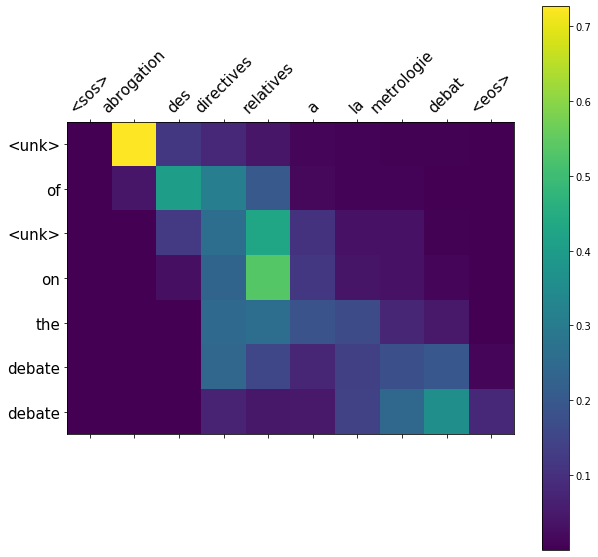

In [166]:
sentence = ' '.join(test_data.examples[5125].src[::-1])
translate = ' '.join(test_data.examples[5125].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)

deuxiemement , par sa portee .
----------------------------------------------------------------------------------------------------
secondly , by the . . . . | -8.737058858325616
----------------------------------------------------------------------------------------------------



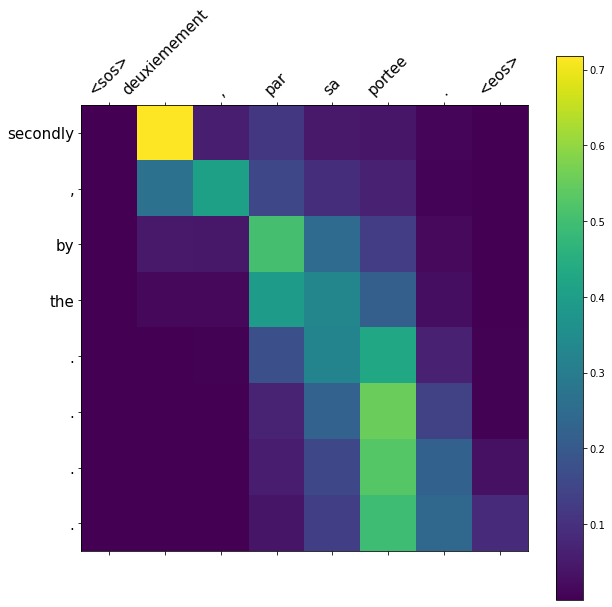

In [167]:
sentence = ' '.join(test_data.examples[3128].src[::-1])
translate = ' '.join(test_data.examples[3128].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)

cela donne les consequences que l on voit .
----------------------------------------------------------------------------------------------------
this gives the consequences the the . | -8.109619960528926
----------------------------------------------------------------------------------------------------
that ha produced consequences that are plain to see .


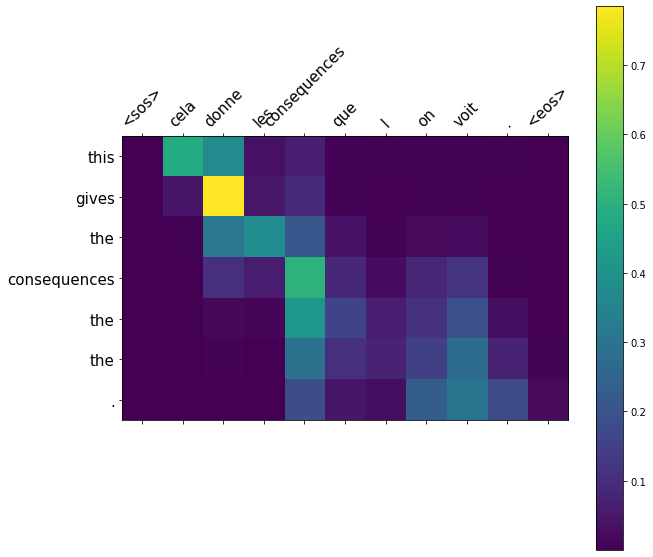

In [169]:
sentence = ' '.join(test_data.examples[3306 ].src[::-1])
translate = ' '.join(test_data.examples[3306].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)

rapport kirkhope
----------------------------------------------------------------------------------------------------
report <unk> 5 8 5 8 5 8 5 8 5 8 5 8 5 8 5 8 5 8 | -27.61334954767147
----------------------------------------------------------------------------------------------------
kirkhope report


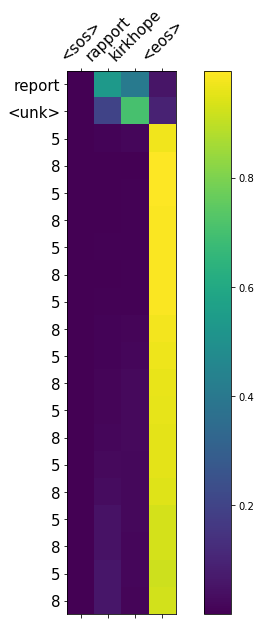

In [170]:
sentence = ' '.join(test_data.examples[1413].src[::-1])
translate = ' '.join(test_data.examples[1413].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)

je vous demanderai d y reflechir
----------------------------------------------------------------------------------------------------
i would like to to to | -7.50751328894882
----------------------------------------------------------------------------------------------------
i would ask for this to be considered .


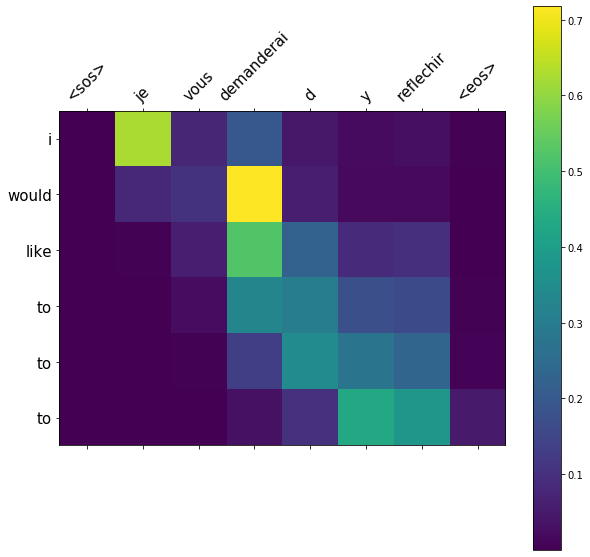

In [171]:
sentence = ' '.join(test_data.examples[3799].src[::-1])
translate = ' '.join(test_data.examples[3799].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)

j aimerais une reponse claire , s il vous plait .
----------------------------------------------------------------------------------------------------
i would like to a answer answer , to to . | -14.097595321352689
----------------------------------------------------------------------------------------------------
a clear reply , if you please .


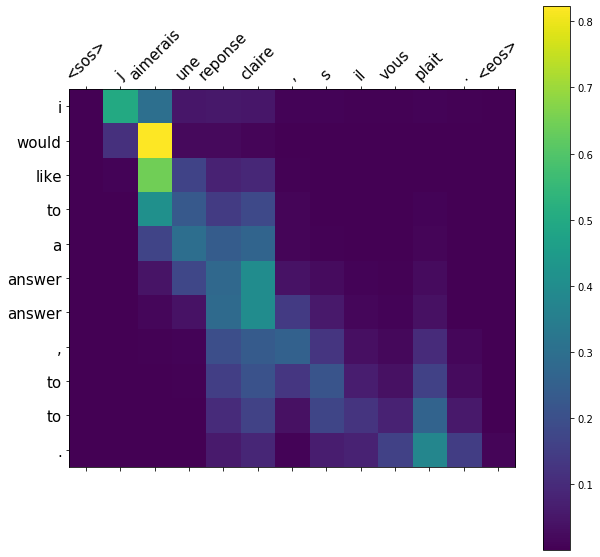

In [172]:
sentence = ' '.join(test_data.examples[357].src[::-1])
translate = ' '.join(test_data.examples[357].dest)
pred_translate, attn_weights, logp = translator.greedy(sentence)

print(sentence)
print('-'*100)
print(pred_translate, '|', logp)
print('-'*100)
print(translate)

display_attention(sentence, pred_translate, attn_weights)